In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import all of them 
sales=pd.read_csv("../data/sales_train.csv")
item_cat=pd.read_csv("../data/item_categories.csv")
item=pd.read_csv("../data/items.csv")
shops=pd.read_csv("../data/shops.csv")
test=pd.read_csv("../data/test.csv")
sub=pd.read_csv("../data/sample_submission.csv")

display(sales.head())
display(item_cat.head())
display(item.head())
display(shops.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [3]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [4]:
# Aggregate to monthly level the required metrics
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"]).agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

display(monthly_sales.head())
## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

,item_name,item_id
item_category_id,,
0,4,4
1,2,2
2,75,75
3,34,34
4,15,15


Text(0.5, 0, 'Category')

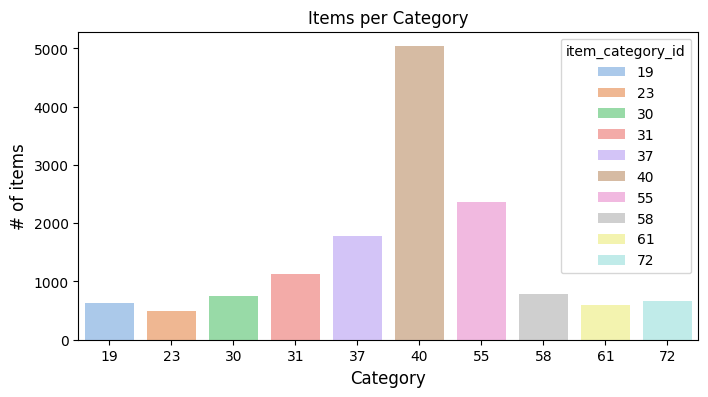

In [5]:
# number of items per category
item.head()
x=item.groupby(['item_category_id']).count()
display(x.head())
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x.head()

# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(data=x, x=x.item_category_id, y=x.item_id, hue="item_category_id", palette="pastel")
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Single series:
Predict for the total sales per month for the entire company.
First let's compute the total sales per month and plot that data.

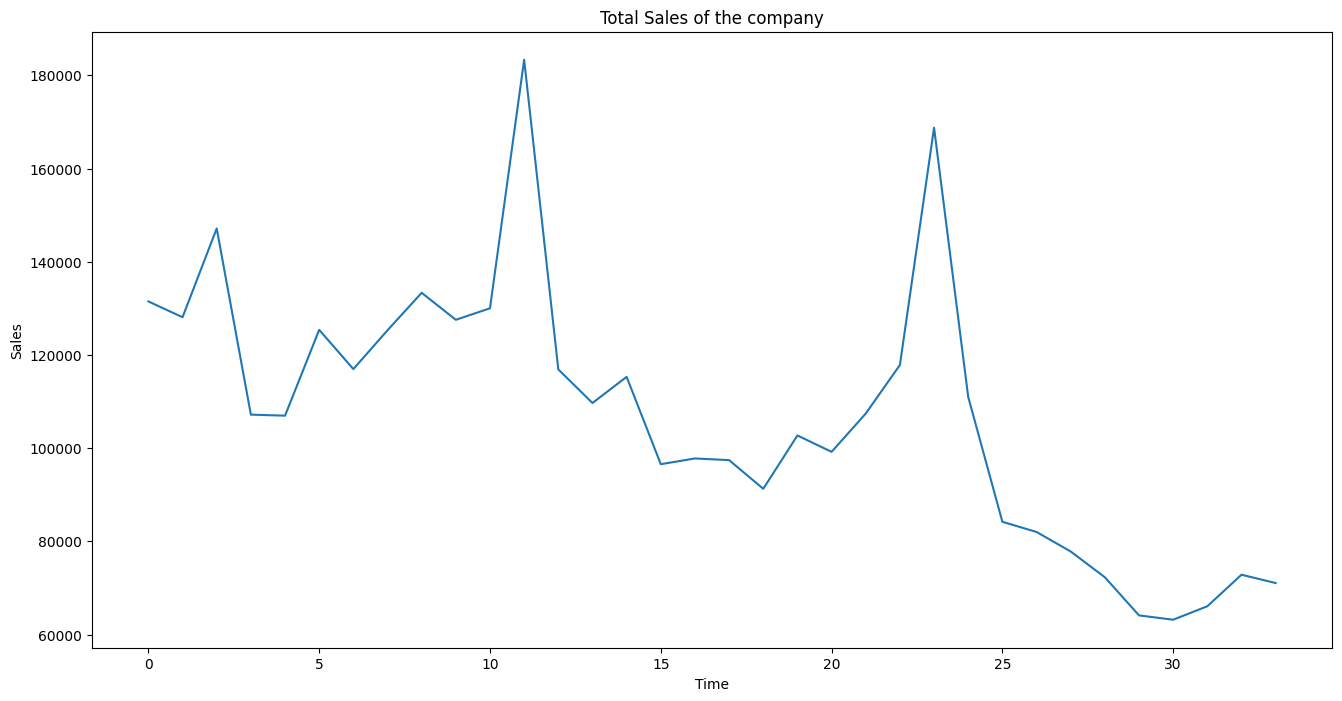

In [6]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

In [7]:
ts.shape

(34,)

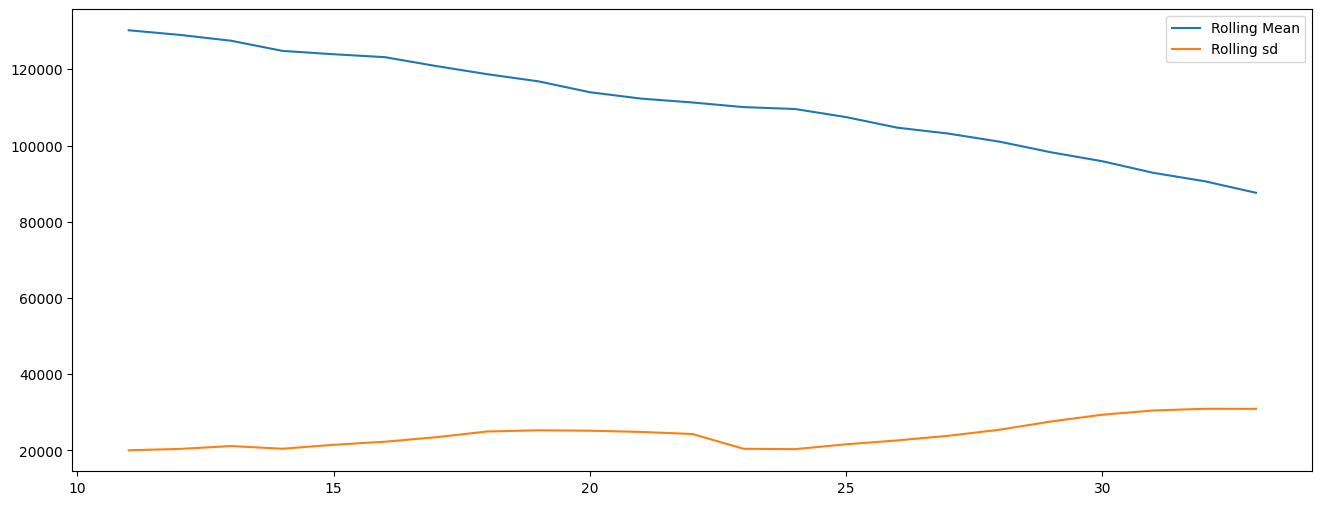

In [8]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

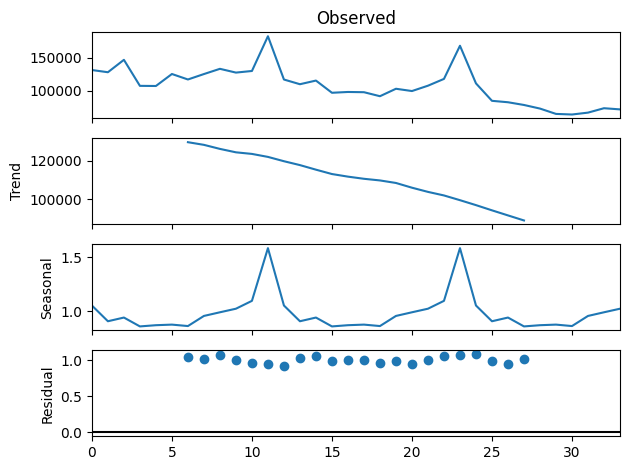

In [9]:
import statsmodels.api as sm

# multiplicative
#have monthly data with an annual cycle, period=12 is appropriate.
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")

#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

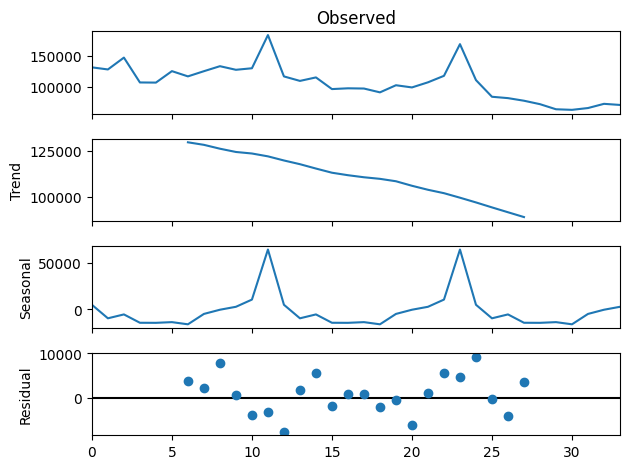

In [10]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

We assume an additive model, then we can write

yt=St+Tt+Et

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative model,

yt=St x Tt x Et

The model parameter in seasonal_decompose can take on the following options:

"additive": Assumes that the time series is a combination of an additive trend, seasonal, and residual component:
    
    Y(t) = Trend(t) + Season(t) + Residual(t)

"multiplicative": Assumes that the time series is a combination of a multiplicative trend, seasonal, and residual component:

    Y(t) = Trend(t) x Season(t) x Residual(t)

"additive_noise" (introduced in statsmodels v0.12.0): It's similar to the additive model but assumes that the residual component has additive noise:

    Y(t) = Trend(t) + Season(t) + Noise(t)


To use the "additive_noise" model, make sure you have an appropriate version of statsmodels. If you're not sure which model to use, consider the nature of your data:

Use additive if the seasonal fluctuations or trend do not change proportionally with the level of the time series.
Use multiplicative if they change proportionally (e.g., higher values in the time series lead to larger seasonal fluctuations).
Use additive_noise if you expect an additive model but with noise in the residuals.

###  Stationarity:

What does it mean for data to be stationary? 
1. The mean of the series should not be a function of time. 
2. The variance of the series should not be a function of time. This property is known as homoscedasticity. 
3. Finally, the covariance of the i th term and the (i + m) th term should not be a function of time.


Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

There are multiple tests that can be used to check stationarity.

    ADF( Augmented Dicky Fuller Test)
    KPSS
    PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

In [11]:
import statsmodels.tsa.stattools as tsa

result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.3957040669944316
p-value: 0.14295257699290492
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


p-value: The p-value is less than the chosen significance level (usually 0.05), you reject the null hypothesis and conclude that the series is stationary.

We will try De-Trend and De-seasonalization

In [12]:
# to remove trend
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

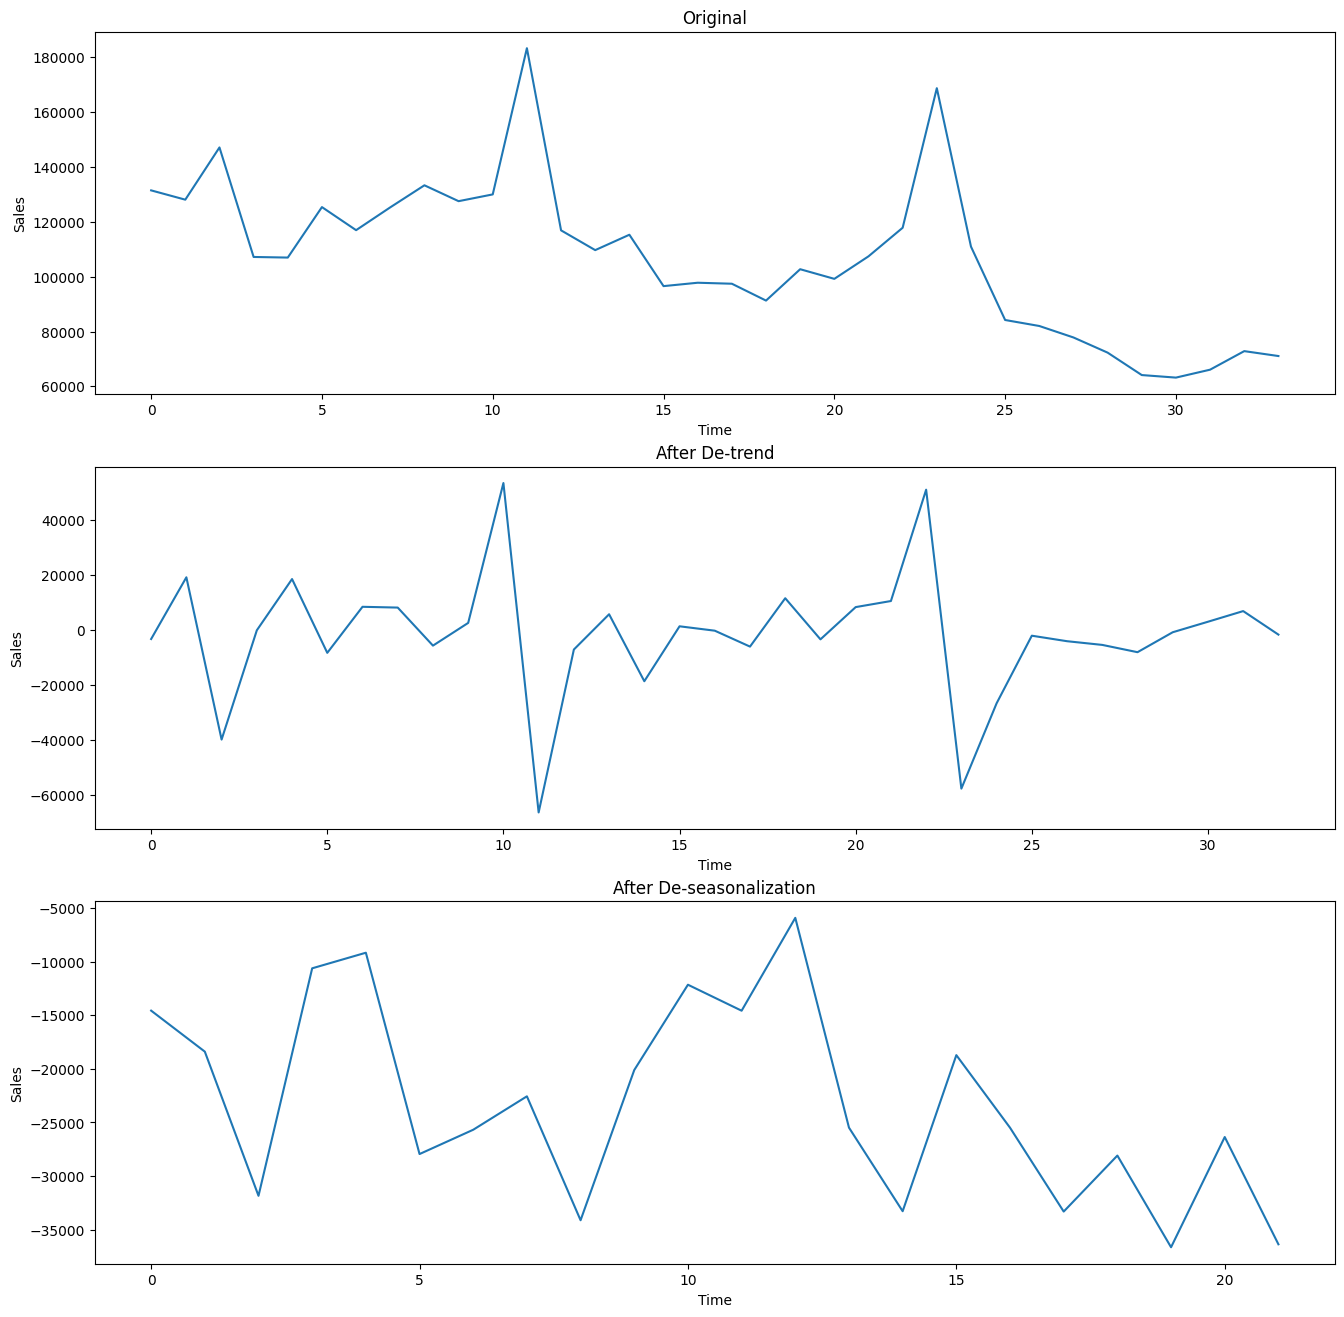

In [13]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts1=difference(ts)
plt.plot(new_ts1)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts2=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts2)
plt.plot()

In [14]:
# now testing the stationarity again after de-trend
result = adfuller(new_ts1)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -13.63622083013242
p-value: 1.6863951222879736e-25
Critical Values: {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}


In [15]:
# now testing the stationarity again after de-seasonality
result = adfuller(new_ts2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.2701011928155475
p-value: 0.016269009923704256
Critical Values: {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}


### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

We can easily get back the original series using the inverse transform function that we have defined above.

Now let's dive into making the forecasts!

In [16]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        tmp_mdl = smt.ARIMA(new_ts2, order=(i, 0, j), trend='n').fit()
        tmp_aic = tmp_mdl.aic
        if tmp_aic < best_aic:
            best_aic = tmp_aic
            best_order = (i, j)
            best_mdl = tmp_mdl


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 473.00311 | order: (1, 1)


We've correctly identified the order of the simulated process as ARMA(1,1).

### Simply use best_mdl.predict() to predict the next values

In [17]:
pred = inverse_difference(best_mdl.forecast(12), ts.tail(12))
display(pred)
pred.index = pred.index + 12
pred

date_block_num
22     87967.862620
23    139027.587381
24     81392.561819
25     54767.789694
26     52731.274748
27     48691.020702
28     43305.031262
29     35269.310111
30     34486.860917
31     37522.687329
32     44429.792977
33     42785.181472
dtype: float64

date_block_num
34     87967.862620
35    139027.587381
36     81392.561819
37     54767.789694
38     52731.274748
39     48691.020702
40     43305.031262
41     35269.310111
42     34486.860917
43     37522.687329
44     44429.792977
45     42785.181472
dtype: float64

In [18]:
comb_new_old = pd.concat([ts, pred])
comb_new_old

date_block_num
0     131479.000000
1     128090.000000
2     147142.000000
3     107190.000000
4     106970.000000
5     125381.000000
6     116966.000000
7     125291.000000
8     133332.000000
9     127541.000000
10    130009.000000
11    183342.000000
12    116899.000000
13    109687.000000
14    115297.000000
15     96556.000000
16     97790.000000
17     97429.000000
18     91280.000000
19    102721.000000
20     99208.000000
21    107422.000000
22    117845.000000
23    168755.000000
24    110971.000000
25     84198.000000
26     82014.000000
27     77827.000000
28     72295.000000
29     64114.000000
30     63187.000000
31     66079.000000
32     72843.000000
33     71056.000000
34     87967.862620
35    139027.587381
36     81392.561819
37     54767.789694
38     52731.274748
39     48691.020702
40     43305.031262
41     35269.310111
42     34486.860917
43     37522.687329
44     44429.792977
45     42785.181472
dtype: float64

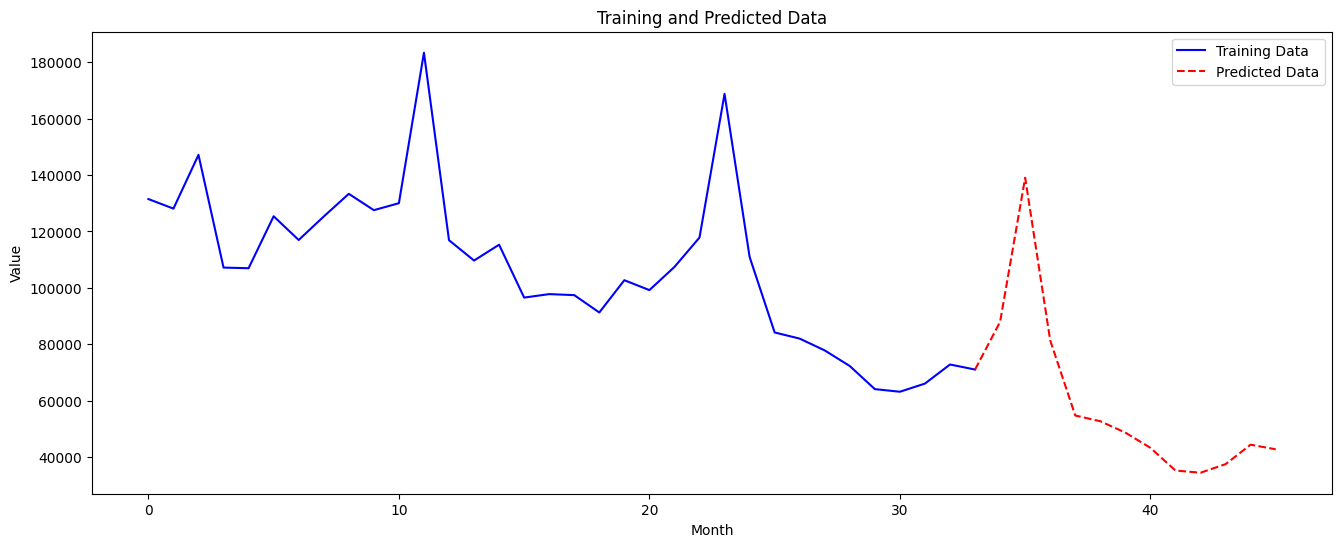

In [19]:
# Separate the data
training_months = range(0,34)
training_values = comb_new_old[0:34]
predicted_months = range(33, 46)
predicted_values = comb_new_old[33:]

# Create the figure and axis
plt.figure(figsize=(16, 6))

# # Plot the training data
plt.plot(training_months, training_values, color='blue', label='Training Data')

# # Plot the predicted data
plt.plot(predicted_months, predicted_values, color='red', linestyle='--', label='Predicted Data')

# Add titles and labels
plt.title('Training and Predicted Data')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()